In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
import csv
import random
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

In [0]:
def generate_ohe(data_x,name):
	new_data = np.asmatrix(np.zeros((data_x.shape[0],85),dtype=int))
	for i in range(len(data_x)):
		for j in range((int)(data_x.shape[1]/2)):
			new_data[i,17*j + data_x[i,2*j]-1] = 1
			new_data[i,17*j + 4 + data_x[i,2*j+1]-1] = 1
	pd.DataFrame(np.array(new_data)).to_csv(name,header=None,index=None)

In [0]:
def scikit_nn(train_x,train_y,test_x,test_y,arch_details,num_iters,batchsize,activation,learning_rate):
	clf = MLPClassifier(alpha=0,shuffle=True,tol=0,warm_start=False,verbose=True,momentum=0,early_stopping=False,solver='sgd',hidden_layer_sizes=arch_details, random_state=1,activation=activation,max_iter=num_iters,batch_size=batchsize,learning_rate_init=learning_rate,learning_rate='constant')
	# clf = MLPClassifier(solver='sgd', alpha=1e-5,random_state=1,activation='relu')
	clf.fit(train_x,modify_output(train_y,10))
	predict = clf.predict(test_x)
	output = np.asmatrix(np.zeros((len(test_y),1)),dtype=int)
	for i in range(len(predict)):
		for j in range(10):
			if predict[i,j]==1:
				output[i,0] = j
	print(confusion_matrix(test_y,output))
	print(accuracy_score(test_y,output))
	# print(clf.coefs_)
	print(clf.get_params())

In [0]:
def read_file(datapath):
	full_data = pd.read_csv(datapath,header=None,dtype=int)
	data_shape = full_data.shape
	full_data_arr = np.array(full_data)
	x = np.asmatrix(full_data_arr[:,0:data_shape[1]-1])
	y = np.asmatrix(full_data_arr[:,data_shape[1]-1:data_shape[1]])
	return (x,y)

In [0]:
def sigmoid_activation(a):
	return 1/(1+np.exp(-1*a))

In [0]:
def sigmoid_derivative(a):
	return np.multiply(sigmoid_activation(a),1-sigmoid_activation(a))

In [0]:
def relu_activation(a):
	return np.multiply(a>0,a)

In [0]:
def relu_RHS_derivative(a):
	return np.multiply(a>=0,np.ones(a.shape,dtype=float))

In [0]:
def relu_LHS_derivative(a):
	return np.multiply(a>0,np.ones(a.shape,dtype=float))

In [0]:
def normalize_data_x(data_x):
	data_x = np.subtract(data_x,np.mean(data_x,axis=0))
	data_x = np.divide(data_x,np.var(data_x,axis=0))
	return data_x

In [0]:
def modify_output(data_y,num_classes):
	output_mat = np.asmatrix(np.zeros((len(data_y),num_classes),dtype=int))
	for i in range(len(data_y)):
		output_mat[i,data_y[i,0]]=1
	return output_mat

In [0]:
def initialize_params(arch_details):
	np.random.seed(1)
	params = {}
	for l in range(1,len(arch_details)):
		params["W"+str(l)] = np.random.randn(arch_details[l],arch_details[l-1])
		params["b"+str(l)] = np.zeros((arch_details[l],1),dtype=float)
	return params

In [0]:
def forward_prop(params,data_x,activation):
	forward_pass = {}
	num_layers = (int)(len(params)/2)
	x = np.transpose(data_x)
	forward_pass["a0"] = x

	if activation=="logistic":
		for i in range(num_layers-1):
			x = np.dot(params["W"+str(i+1)],x) + params["b"+str(i+1)]
			forward_pass["z"+str(i+1)] = x
			x = sigmoid_activation(x)
			forward_pass["a"+str(i+1)] = x
	else:
		for i in range(num_layers-1):
			x = np.dot(params["W"+str(i+1)],x) + params["b"+str(i+1)]
			forward_pass["z"+str(i+1)] = x
			x = relu_activation(x)
			forward_pass["a"+str(i+1)] = x

	x = np.dot(params["W"+str(num_layers)],x) + params["b"+str(num_layers)]
	forward_pass["z"+str(num_layers)] = x
	x = sigmoid_activation(x)
	forward_pass["a"+str(num_layers)] = x
	return forward_pass

In [0]:
def loss_function(output_layer_output,actual_output):
	loss = np.multiply(output_layer_output-actual_output,output_layer_output-actual_output)
	return (-1*np.mean(loss,axis=1)/(output_layer_output.shape[1]))

In [0]:
def backward_prop(params,forward_pass,learning_rate,y_data,activation):
	der_dict = {}
	new_params = {}
	m = y_data.shape[1]
	der_output = np.multiply(forward_pass["a"+str((int)(len(params)/2))] - y_data,sigmoid_derivative(forward_pass["z"+str((int)(len(params)/2))]))
	# der_output = forward_pass["a"+str(len(params)/2)] - y_data
	der_dict["dZ"+str((int)(len(params)/2))] = der_output
	
	if activation=="logistic":
		for i in range((int)(len(params)/2) - 1,0,-1):
			der_output = np.multiply(np.dot(np.transpose(params["W"+str(i+1)]),der_dict["dZ"+str(i+1)]),sigmoid_derivative(forward_pass["z"+str(i)]))
			der_dict["dZ"+str(i)] = der_output

		for i in range(1,(int)(len(params)/2) +1):
			new_params["W"+str(i)] = params["W"+str(i)] - (learning_rate/m)*np.dot(der_dict["dZ"+str(i)],np.transpose(forward_pass["a"+str(i-1)]))
			new_params["b"+str(i)] = params["b"+str(i)] - (learning_rate/m)*np.sum(der_dict["dZ"+str(i)],axis=1)
	else:
		for i in range((int)(len(params)/2) - 1,0,-1):
			der_output = np.multiply(np.dot(np.transpose(params["W"+str(i+1)]),der_dict["dZ"+str(i+1)]),relu_RHS_derivative(forward_pass["z"+str(i)]))
			der_dict["dZ"+str(i)] = der_output

		for i in range(1,(int)(len(params)/2) +1):
			new_params["W"+str(i)] = params["W"+str(i)] - (learning_rate/m)*np.dot(der_dict["dZ"+str(i)],np.transpose(forward_pass["a"+str(i-1)]))
			new_params["b"+str(i)] = params["b"+str(i)] - (learning_rate/m)*np.sum(der_dict["dZ"+str(i)],axis=1)
	return new_params

In [0]:
def prediction(params,data_x,activation):
	forward_pass = {}
	x = np.transpose(data_x)
	for i in range((int)(len(params)/2)):
		x = np.dot(params["W"+str(i+1)],x) + params["b"+str(i+1)]
		forward_pass["z"+str(i+1)] = x
		x = sigmoid_activation(x)
		forward_pass["a"+str(i+1)] = x
	output = np.exp(forward_pass["a"+str((int)(len(params)/2))])
	summer = np.sum(output,axis=0)
	output = np.divide(output,summer)
	return np.argmax(output,axis=0)

In [0]:
def main(architecture_details,learning_rate,epochs,batch_size,activation):
	train_datapath = "drive/My Drive/ML_Datasets/neural_nets/poker-hand-training-true.data"
	test_datapath = "drive/My Drive/ML_Datasets/neural_nets/poker-hand-testing.data"
#   test_datapath = "drive/My Drive/ML_Datasets/neural_nets/poker-hand-training-true.data"

# 	train_datapath = "drive/My Drive/ML_Datasets/mnist/train.csv"
# 	test_datapath = "drive/My Drive/ML_Datasets/mnist/test.csv"
	
	(train_x,train_y) = read_file(train_datapath)
	(test_x,test_y) = read_file(test_datapath)
	# train_x = normalize_data_x(train_x)
	# test_x = normalize_data_x(test_x)
	
	# generate_ohe(train_x,"train_x.csv")
	# generate_ohe(test_x,"test_x.csv")

	train_x = np.asmatrix(pd.read_csv("drive/My Drive/ML_Datasets/neural_nets/train_x.csv",header=None,dtype=int))
	test_x = np.asmatrix(pd.read_csv("drive/My Drive/ML_Datasets/neural_nets/test_x.csv",header=None,dtype=int))
#   test_x = np.asmatrix(pd.read_csv("drive/My Drive/ML_Datasets/neural_nets/train_x.csv",header=None,dtype=int))

# 	learning_rate = 0.1
# 	architecture_details = [25]
	num_outputs = 10
# 	epochs = 2000
# 	batch_size = 100
	num_datapoints = len(train_x)
	modified_y = modify_output(train_y,num_outputs)
	error = 10
	epsilon = 1e-5
	
	neurons_list = [train_x.shape[1]]
	neurons_list.extend(architecture_details)
	neurons_list.append(num_outputs)
# 	activation = "logistic"
	# activation = "relu"
	params = initialize_params(neurons_list)
	# scikit_nn(train_x,train_y,test_x,test_y,architecture_details,epochs,batch_size,activation,learning_rate)
	cost_list = []
	counter = 0
	
	while error>epsilon and counter<epochs:
# 		train_x = np.random.permutation(train_x)
		for batch_counter in range((int)(num_datapoints/batch_size)):
			begin = batch_counter*batch_size
			end = begin+batch_size
			if batch_counter==(num_datapoints/batch_size)-1:
				end = num_datapoints
			forward_pass  = forward_prop(params,train_x[begin:end,:],activation)
			loss_mag = loss_function(forward_pass["a"+str((int)(len(params)/2))],np.transpose(modified_y[begin:end,:]))
			params = backward_prop(params,forward_pass,learning_rate,np.transpose(modified_y[begin:end,:]),activation)
		error = np.sqrt(np.dot(loss_mag,np.transpose(loss_mag))[0,0])
		print(str(counter) + " : " + str(error))
		cost_list.append(error)
		counter+=1
	
	predicted = np.transpose(prediction(params,test_x,activation))
	confatrix = confusion_matrix(test_y,predicted)
	print(confatrix)
	print(accuracy_score(test_y,predicted))
	plt.plot(cost_list)
	plt.show()

In [0]:
def main2(architecture_details,learning_rate,epochs,batch_size,activation):
	train_datapath = "drive/My Drive/ML_Datasets/neural_nets/poker-hand-training-true.data"
	test_datapath = "drive/My Drive/ML_Datasets/neural_nets/poker-hand-training-true.data"
#   test_datapath = "drive/My Drive/ML_Datasets/neural_nets/poker-hand-training-true.data"

# 	train_datapath = "drive/My Drive/ML_Datasets/mnist/train.csv"
# 	test_datapath = "drive/My Drive/ML_Datasets/mnist/test.csv"
	
	(train_x,train_y) = read_file(train_datapath)
	(test_x,test_y) = read_file(test_datapath)
	# train_x = normalize_data_x(train_x)
	# test_x = normalize_data_x(test_x)
	
	# generate_ohe(train_x,"train_x.csv")
	# generate_ohe(test_x,"test_x.csv")

	train_x = np.asmatrix(pd.read_csv("drive/My Drive/ML_Datasets/neural_nets/train_x.csv",header=None,dtype=int))
	test_x = np.asmatrix(pd.read_csv("drive/My Drive/ML_Datasets/neural_nets/train_x.csv",header=None,dtype=int))
#   test_x = np.asmatrix(pd.read_csv("drive/My Drive/ML_Datasets/neural_nets/train_x.csv",header=None,dtype=int))

# 	learning_rate = 0.1
# 	architecture_details = [25]
	num_outputs = 10
# 	epochs = 2000
# 	batch_size = 100
	num_datapoints = len(train_x)
	modified_y = modify_output(train_y,num_outputs)
	
# 	activation = "logistic"
	# activation = "relu"
# 	params = initialize_params(neurons_list)
	scikit_nn(train_x,train_y,test_x,test_y,architecture_details,epochs,batch_size,activation,learning_rate)

In [0]:
architecture_details=[25]
learning_rate = 0.1
epochs = 1000
batch_size = 25
activation = "logistic"

In [0]:
main2(architecture_details,learning_rate,epochs,batch_size,activation)

Iteration 1, loss = 2.08362462
Iteration 2, loss = 1.75176714
Iteration 3, loss = 1.73744814
Iteration 4, loss = 1.73235173
Iteration 5, loss = 1.73020949
Iteration 6, loss = 1.72860012
Iteration 7, loss = 1.72791730
Iteration 8, loss = 1.72734503
Iteration 9, loss = 1.72693465
Iteration 10, loss = 1.72655696
Iteration 11, loss = 1.72628013
Iteration 12, loss = 1.72597174
Iteration 13, loss = 1.72560913
Iteration 14, loss = 1.72542708
Iteration 15, loss = 1.72538902
Iteration 16, loss = 1.72548670
Iteration 17, loss = 1.72508645
Iteration 18, loss = 1.72509035
Iteration 19, loss = 1.72488542
Iteration 20, loss = 1.72477201
Iteration 21, loss = 1.72466922
Iteration 22, loss = 1.72481233
Iteration 23, loss = 1.72461996
Iteration 24, loss = 1.72440806
Iteration 25, loss = 1.72425156
Iteration 26, loss = 1.72421785
Iteration 27, loss = 1.72439395
Iteration 28, loss = 1.72426902
Iteration 29, loss = 1.72434550
Iteration 30, loss = 1.72427424
Iteration 31, loss = 1.72413850
Iteration 32, los

Above is for train_x.csv and test_x.csv


Below one is for testing on test datase only. 
##Parameters are as followed
architecture_details=25</br>
learning_rate = 0.1</br>
epochs = 1000</br>
batch_size = 25</br>
activation = "logistic"</br>

0 : 0.010140359289724666
1 : 0.010342377621481878
2 : 0.010541820932543996
3 : 0.010601585268635763
4 : 0.010568630216056966
5 : 0.010498699253953645
6 : 0.010422037558067582
7 : 0.010351158591548388
8 : 0.010289940202871401
9 : 0.010238646481040736
10 : 0.010196240338124583
11 : 0.010161358626289453
12 : 0.010132688484972395
13 : 0.010109089440650287
14 : 0.010089613419549337
15 : 0.010073487718447157
16 : 0.010060087727473471
17 : 0.010048909743206403
18 : 0.010039547308398724
19 : 0.010031671746900984
20 : 0.010025016552263667
21 : 0.010019365002160939
22 : 0.010014540363887667
23 : 0.01001039814222052
24 : 0.010006819925116586
25 : 0.010003708477866998
26 : 0.010000983814859312
27 : 0.009998580040006077
28 : 0.009996442794612835
29 : 0.009994527187872996
30 : 0.00999279611288356
31 : 0.009991218872185254
32 : 0.009989770052978223
33 : 0.009988428604586283
34 : 0.009987177080361224
35 : 0.009986001013719359
36 : 0.009984888403892462
37 : 0.009983829291632695
38 : 0.00998281540881736

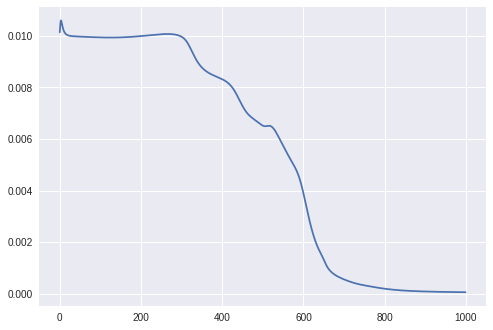

In [0]:
main(architecture_details,learning_rate,epochs,batch_size,activation)

Below one is for testing on training set only. 
##Parameters are as followed
architecture_details=25</br>
learning_rate = 0.1</br>
epochs = 1000</br>
batch_size = 25</br>
activation = "logistic"</br>


0 : 0.010140359289724666
1 : 0.010342377621481878
2 : 0.010541820932543996
3 : 0.010601585268635763
4 : 0.010568630216056966
5 : 0.010498699253953645
6 : 0.010422037558067582
7 : 0.010351158591548388
8 : 0.010289940202871401
9 : 0.010238646481040736
10 : 0.010196240338124583
11 : 0.010161358626289453
12 : 0.010132688484972395
13 : 0.010109089440650287
14 : 0.010089613419549337
15 : 0.010073487718447157
16 : 0.010060087727473471
17 : 0.010048909743206403
18 : 0.010039547308398724
19 : 0.010031671746900984
20 : 0.010025016552263667
21 : 0.010019365002160939
22 : 0.010014540363887667
23 : 0.01001039814222052
24 : 0.010006819925116586
25 : 0.010003708477866998
26 : 0.010000983814859312
27 : 0.009998580040006077
28 : 0.009996442794612835
29 : 0.009994527187872996
30 : 0.00999279611288356
31 : 0.009991218872185254
32 : 0.009989770052978223
33 : 0.009988428604586283
34 : 0.009987177080361224
35 : 0.009986001013719359
36 : 0.009984888403892462
37 : 0.009983829291632695
38 : 0.00998281540881736

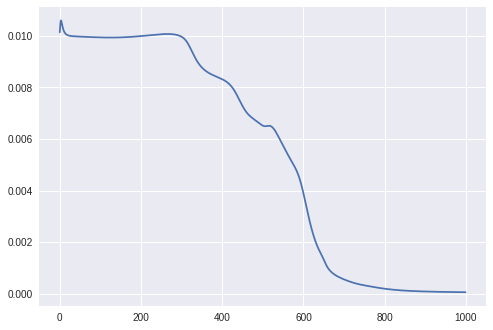

In [0]:
main(architecture_details,learning_rate,epochs,batch_size,activation)

###Below is also for testing on test set with the same params

0 : 0.010140359289724666
1 : 0.010342377621481878
2 : 0.010541820932543996
3 : 0.010601585268635763
4 : 0.010568630216056966
5 : 0.010498699253953645
6 : 0.010422037558067582
7 : 0.010351158591548388
8 : 0.010289940202871401
9 : 0.010238646481040736
10 : 0.010196240338124583
11 : 0.010161358626289453
12 : 0.010132688484972395
13 : 0.010109089440650287
14 : 0.010089613419549337
15 : 0.010073487718447157
16 : 0.010060087727473471
17 : 0.010048909743206403
18 : 0.010039547308398724
19 : 0.010031671746900984
20 : 0.010025016552263667
21 : 0.010019365002160939
22 : 0.010014540363887667
23 : 0.01001039814222052
24 : 0.010006819925116586
25 : 0.010003708477866998
26 : 0.010000983814859312
27 : 0.009998580040006077
28 : 0.009996442794612835
29 : 0.009994527187872996
30 : 0.00999279611288356
31 : 0.009991218872185254
32 : 0.009989770052978223
33 : 0.009988428604586283
34 : 0.009987177080361224
35 : 0.009986001013719359
36 : 0.009984888403892462
37 : 0.009983829291632695
38 : 0.00998281540881736

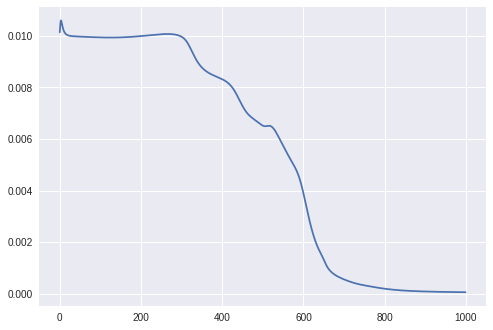

In [0]:
main(architecture_details,learning_rate,epochs,batch_size,activation)